# First things first

The National Agency of Petroleum, Natural Gas and Bio fuels (ANP in Portuguese) releases weekly reports of gas, diesel and other fuels prices used in transportation across the country. 

https://www.kaggle.com/matheusfreitag/gas-prices-in-brazil/data

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
data = pd.read_csv('2004-2019.tsv', sep = '\t', index_col = 0)
data.sample(3) # Let's take a look

,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO,MÊS,ANO
28933,2007-10-14,2007-10-20,SUL,SANTA CATARINA,GLP,418,R$/13Kg,35.402,1.422,31.000,39.90,6.137,0.040,29.265,2.613,23,34.5,0.089,10,2007
69267,2014-09-14,2014-09-20,SUDESTE,MINAS GERAIS,GASOLINA COMUM,973,R$/l,2.968,0.127,2.699,3.35,0.375,0.043,2.593,0.054,2.439,2.7479,0.021,9,2014
100549,2018-09-09,2018-09-15,NORTE,TOCANTINS,ETANOL HIDRATADO,36,R$/l,3.661,0.162,3.399,4.10,0.548,0.044,3.113,0.187,2.6799,3.2982,0.06,9,2018


## Diesel prices modeling

In [3]:
diesel = data[data.PRODUTO == 'ÓLEO DIESEL'].copy()

formating date columns (weekly instances from data.info())

In [4]:
diesel['DATA INICIAL'] = pd.to_datetime(diesel['DATA INICIAL']) # Date columns are str instead of DateTime
diesel['DATA FINAL'] = pd.to_datetime(diesel['DATA FINAL']) # Date columns are str instead of DateTime

Dataset splits

In [5]:
diesel_train = diesel[diesel['DATA FINAL'] < '2011-05-15'] # 7 years 
diesel_val   = diesel[(diesel['DATA FINAL'] >= '2011-05-15') & (diesel['DATA FINAL'] < '2018-01-01')] # 7 years
diesel_test  = diesel[diesel['DATA FINAL'] >= '2018-05-15'] # 1 year
diesel_train.shape, diesel_val.shape, diesel_test.shape 

((9773, 20), (9315, 20), (1593, 20))

**Target definition**

In [6]:
y_train = diesel_train['PREÇO MÉDIO REVENDA']
y_val   = diesel_val['PREÇO MÉDIO REVENDA']
y_test  = diesel_test['PREÇO MÉDIO REVENDA']

Mini exploration

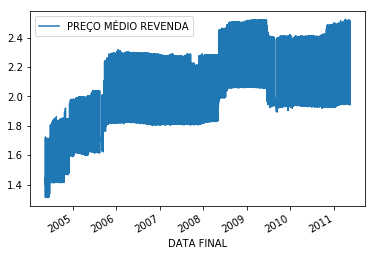

In [7]:
diesel_train.plot(x = 'DATA FINAL', y = 'PREÇO MÉDIO REVENDA') # The target is not stationary!!!! 

After seeing both variance and mean changing through time, let's created the variable current_price - future_price and examine its plot

In [8]:
def target_diff(x):
    """ Compute the difference between two consecutives rows in a serie """
    x = x.diff() # First discrete difference for a Serie
    x = x.shift(-1) # shifting its result at the same level (leaving last element as nan)
    return x

In [9]:
diesel_train['DIFF'] = diesel_train.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].apply(target_diff)
diesel_val['DIFF']   = diesel_val.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].apply(target_diff)
diesel_test['DIFF']  = diesel_test.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].apply(target_diff)

C:\Users\vipac\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\vipac\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\vipac\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

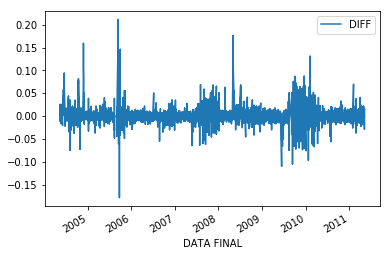

In [10]:
diesel_train.plot(x = 'DATA FINAL', y = 'DIFF') # these behaviors are better for Time Series

## Selecting features

Let's create a new dataframe with features used to modeling

In [11]:
df_X_train = pd.DataFrame(index = diesel_train.index)
df_X_val   = pd.DataFrame(index = diesel_val.index)
df_X_test  = pd.DataFrame(index = diesel_test.index)

**Train set**

In [12]:
######## SEASONAL ########
df_X_train['DAY'] = diesel_train['DATA FINAL'].dt.day
df_X_train['MONTH'] = diesel_train['DATA FINAL'].dt.month
df_X_train['DAY_of_YEAR'] = diesel_train['DATA FINAL'].dt.dayofyear

######## LAG (Rezago :P ) ########
df_X_train['LAG'] = diesel_train['PREÇO MÉDIO REVENDA']
df_X_train['DIFF_LAG'] = diesel_train.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].diff()

######## MA (moving average) ########
df_X_train['MA'] = diesel_train.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].rolling(4).mean().reset_index(level = 0, drop = True)

################
df_X_train['DIFF'] = diesel_train['DIFF']
df_X_train = df_X_train.dropna()

X_train = df_X_train.drop(['DIFF'], axis = 1)
y_train = df_X_train['DIFF']

In [13]:
X_train.describe()

,DAY,MONTH,DAY_of_YEAR,LAG,DIFF_LAG,MA
count,9665.000000,9665.000000,9665.000000,9665.000000,9665.000000,9665.000000
mean,15.612519,6.505225,182.475841,1.951631,0.001822,1.948900
std,8.784286,3.480967,106.299947,0.208517,0.017622,0.210385
min,1.000000,1.000000,1.000000,1.313000,-0.177000,1.314000
25%,8.000000,3.000000,90.000000,1.841000,-0.002000,1.839250
50%,16.000000,7.000000,182.000000,1.959000,0.000000,1.957000
75%,23.000000,10.000000,276.000000,2.078000,0.003000,2.077000
max,31.000000,12.000000,365.000000,2.523000,0.211000,2.520500


**Val set**

In [14]:
######## SEASONAL ########
df_X_val['DAY'] = diesel_val['DATA FINAL'].dt.day
df_X_val['MONTH'] = diesel_val['DATA FINAL'].dt.month
df_X_val['DAY_of_YEAR'] = diesel_val['DATA FINAL'].dt.dayofyear

######## LAG (Rezago :P ) ########
df_X_val['LAG'] = diesel_val['PREÇO MÉDIO REVENDA']
df_X_val['DIFF_LAG'] = diesel_val.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].diff()

######## MA (moving average) ########
df_X_val['MA'] = diesel_val.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].rolling(4).mean().reset_index(level = 0, drop = True)

################
df_X_val['DIFF'] = diesel_val['DIFF']
df_X_val = df_X_val.dropna()

X_val = df_X_val.drop(['DIFF'], axis = 1)
y_val = df_X_val['DIFF']

**Test set**

In [15]:
######## SEASONAL ########
df_X_test['DAY'] = diesel_test['DATA FINAL'].dt.day
df_X_test['MONTH'] = diesel_test['DATA FINAL'].dt.month
df_X_test['DAY_of_YEAR'] = diesel_test['DATA FINAL'].dt.dayofyear

######## LAG (Rezago :P ) ########
df_X_test['LAG'] = diesel_test['PREÇO MÉDIO REVENDA']
df_X_test['DIFF_LAG'] = diesel_test.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].diff()

######## MA (moving average) ########
df_X_test['MA'] = diesel_test.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].rolling(4).mean().reset_index(level = 0, drop = True)

################
df_X_test['DIFF'] = diesel_test['DIFF']
df_X_test = df_X_test.dropna()

X_test = df_X_test.drop(['DIFF'], axis = 1)
y_test = df_X_test['DIFF']

## Model

In [16]:
from sklearn.ensemble import RandomForestRegressor

In [17]:
clf = RandomForestRegressor(n_estimators = 500, random_state = 21)
clf.fit(X_train,y_train)
preds = clf.predict(X_val)

In [18]:
from sklearn.metrics import mean_squared_log_error

error = np.sqrt(mean_squared_log_error(
    X_val['LAG'] + y_val, X_val['LAG'] + preds)) # Root mean squared logarithmic error 
print('error:', error*100)

error: 0.6855239815574414


## Feature selection

In [19]:
for feature in X_train.columns:
    clf = RandomForestRegressor(n_estimators = 500, random_state = 21)
    clf.fit(X_train[[feature]], y_train)
    preds = clf.predict(X_val[[feature]])
    
    error = np.sqrt(mean_squared_log_error(X_val['LAG'] + y_val, X_val['LAG'] + preds))*100
    print('feature:', feature, '-> error:',round(error, 4))

feature: DAY -> error: 0.6706
feature: MONTH -> error: 0.6621
feature: DAY_of_YEAR -> error: 0.7716
feature: LAG -> error: 0.7493
feature: DIFF_LAG -> error: 0.6654
feature: MA -> error: 0.6952
